# Presentation

1. Title: Auto-Mpg Data

2. Sources:
   (a) Origin: This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset       was used in the 1983 American Statistical Association Exposition.
   (c) Date: July 7, 1993

3. Past Usage:
    -  See 2b (above)
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed 
   because they had unknown values for the "mpg" attribute.  The original 
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumption in miles per gallon,
    to be predicted in terms of 3 multivalued discrete and 5 continuous
    attributes." (Quinlan, 1993)

5. Number of Instances: 398

6. Number of Attributes: 9 including the class attribute

7. Attribute Information:
    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

8. Missing Attribute Values:  horsepower has 6 missing values


## Imports

In [1]:
import io
from scipy import misc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

%matplotlib inline

## Loading and Explorations of Datas

In [2]:
dataset = pd.read_csv("data_clear.csv", delim_whitespace=True, \
                      names = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "age", "origin", "name"])

In [3]:
print(dataset.head(), "\n" )
print(dataset.info(), "\n")
print(dataset.describe(), "\n")

    mpg  cylinders  displacement horsepower  weight  acceleration  age  \
0  18.0          8         307.0      130.0  3504.0          12.0   70   
1  15.0          8         350.0      165.0  3693.0          11.5   70   
2  18.0          8         318.0      150.0  3436.0          11.0   70   
3  16.0          8         304.0      150.0  3433.0          12.0   70   
4  17.0          8         302.0      140.0  3449.0          10.5   70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null floa

in that case, it makes no sense to keep the car name. We cannot extract anything from this data. We can reduce by 1 dimension our problem by directly removing it

In [4]:
dataset = dataset.drop(["name"], axis=1)

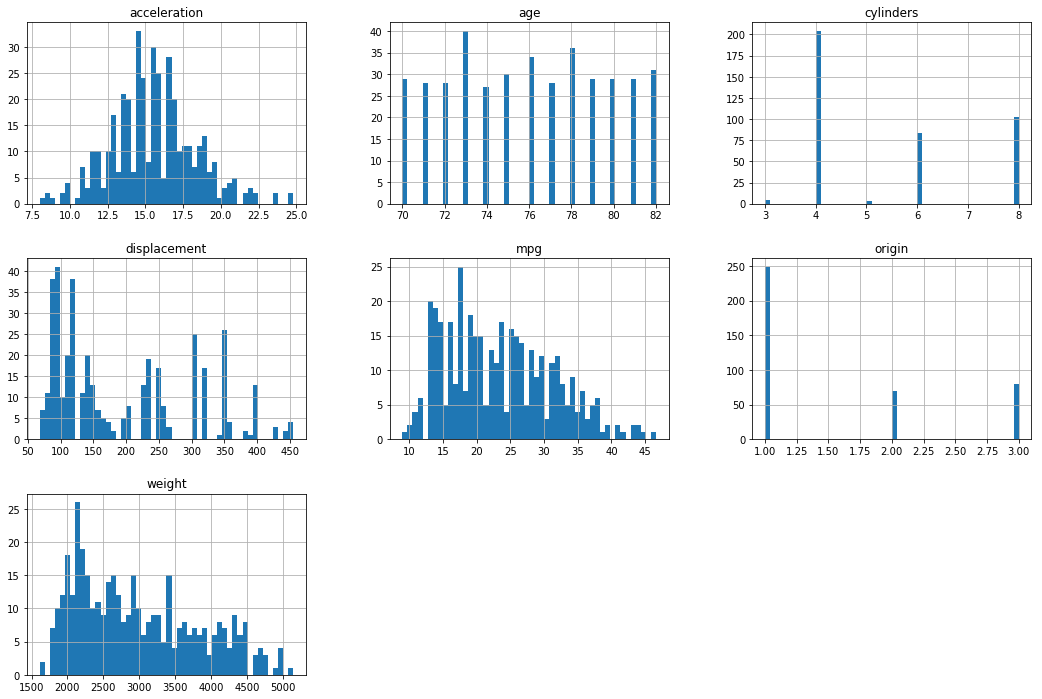

In [5]:
dataset.hist(bins=50, figsize=(18,12))
plt.show()

In [6]:
print(dataset["origin"].value_counts())
print(dataset["cylinders"].value_counts())
print(dataset["age"].value_counts())

1    249
3     79
2     70
Name: origin, dtype: int64
4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64
73    40
78    36
76    34
82    31
75    30
81    29
80    29
79    29
70    29
77    28
72    28
71    28
74    27
Name: age, dtype: int64


As mentionned in the dataset presentation, there is 6 values missing in horsepower. For this we can either delete the corresponding line from the dataset or fill it with the median for example. The second solution makes no sense as we could create outlier with this solution (for example set a median horsepower on a car with a huge mpg). For this example we should better decide to remove the lines

In [7]:
dataset = dataset.drop(dataset[dataset['horsepower'] == '?'].index)

from the dataset we also have the manufactured date of the car. As we can imagine, the older the car is, the more it consumes. A better relation would be to set their age instead. This can be done just by calculating the age of the car when data were extracted (1983).

In [8]:
def mapper(year):
    return 83 - year

dataset["age"] = dataset["age"].apply(mapper)
print(dataset.describe(), "\n")

              mpg   cylinders  displacement       weight  acceleration  \
count  392.000000  392.000000    392.000000   392.000000    392.000000   
mean    23.445918    5.471939    194.411990  2977.584184     15.541327   
std      7.805007    1.705783    104.644004   849.402560      2.758864   
min      9.000000    3.000000     68.000000  1613.000000      8.000000   
25%     17.000000    4.000000    105.000000  2225.250000     13.775000   
50%     22.750000    4.000000    151.000000  2803.500000     15.500000   
75%     29.000000    8.000000    275.750000  3614.750000     17.025000   
max     46.600000    8.000000    455.000000  5140.000000     24.800000   

              age      origin  
count  392.000000  392.000000  
mean     7.020408    1.576531  
std      3.683737    0.805518  
min      1.000000    1.000000  
25%      4.000000    1.000000  
50%      7.000000    1.000000  
75%     10.000000    2.000000  
max     13.000000    3.000000   



From what we see in cylinders features, we could maybe simplify our model by being rid off 3 and 5 cylinders (they represent only 7/398 instances which is less than 2 percents)

In [9]:
dataset = dataset.drop(dataset[dataset['cylinders'] == 3].index)
dataset = dataset.drop(dataset[dataset['cylinders'] == 5].index)

In [10]:
corr_matrix = dataset.corr()
print(corr_matrix)

                   mpg  cylinders  displacement    weight  acceleration  \
mpg           1.000000  -0.794872     -0.817887 -0.842681      0.419337   
cylinders    -0.794872   1.000000      0.950701  0.900707     -0.525945   
displacement -0.817887   0.950701      1.000000  0.935296     -0.560622   
weight       -0.842681   0.900707      0.935296  1.000000     -0.431067   
acceleration  0.419337  -0.525945     -0.560622 -0.431067      1.000000   
age          -0.579778   0.352061      0.373971  0.315424     -0.287195   
origin        0.582881  -0.557105     -0.606698 -0.585251      0.229589   

                   age    origin  
mpg          -0.579778  0.582881  
cylinders     0.352061 -0.557105  
displacement  0.373971 -0.606698  
weight        0.315424 -0.585251  
acceleration -0.287195  0.229589  
age           1.000000 -0.184913  
origin       -0.184913  1.000000  


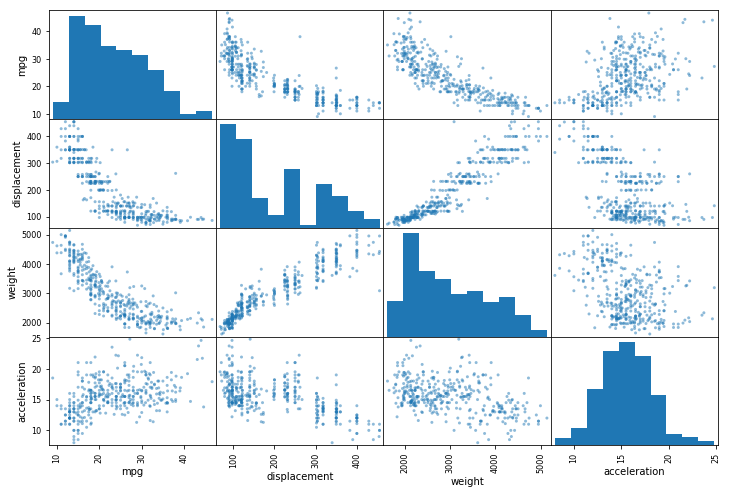

In [11]:
attributes = ["mpg", "displacement", "weight", "acceleration"]
pd.plotting.scatter_matrix(dataset[attributes], figsize = (12,8))
plt.show()

## Splitting and Preparing datas

In [12]:
training_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)
print("Training set : \n")
print(training_set.info(), "\n")
print(training_set.describe(), "\n\n")
print("Test set : \n")
print(test_set.info(), "\n")
print(test_set.describe(), "\n")

Training set : 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 169 to 104
Data columns (total 8 columns):
mpg             308 non-null float64
cylinders       308 non-null int64
displacement    308 non-null float64
horsepower      308 non-null object
weight          308 non-null float64
acceleration    308 non-null float64
age             308 non-null int64
origin          308 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 21.7+ KB
None 

              mpg   cylinders  displacement       weight  acceleration  \
count  308.000000  308.000000    308.000000   308.000000    308.000000   
mean    23.707143    5.512987    195.733766  2978.077922     15.579221   
std      8.055395    1.695893    103.898318   858.365286      2.740032   
min      9.000000    4.000000     71.000000  1613.000000      8.000000   
25%     17.375000    4.000000    105.000000  2204.250000     13.900000   
50%     23.000000    4.000000    151.000000  2866.500000     15.500000   


In [13]:
y = training_set["mpg"].copy()
X = training_set.drop(["mpg"], axis=1)
print("Y :", y.shape)
print("X :", X.shape)

Y : (308,)
X : (308, 7)


In [14]:
pipeline = Pipeline([
    ('std_scaler', MinMaxScaler()),
])

In [15]:
X_transform = pipeline.fit_transform(X)

some_data = X_transform[:5]
some_label = y[:5]

## Trying some algorithms

For a first try we can evaluate some standards regression algorithms and checking the RMSE

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_transform, y)

print("Prediction", lin_reg.predict(some_data), "\n")
print("Reality", list(some_label) , "\n")

prediction = lin_reg.predict(X_transform)
lin_mse = mean_squared_error(prediction, y)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

Prediction [ 22.51715682  33.8600233   15.29035558  15.07601215  25.20161207] 

Reality [20.0, 33.799999999999997, 15.0, 13.0, 25.5] 

3.23558249252


In [17]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_transform, y)

print("Prediction", tree_reg.predict(some_data), "\n")
print("Reality", list(some_label) , "\n")

prediction = tree_reg.predict(X_transform)
tree_mse = mean_squared_error(prediction, y)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

Prediction [ 20.   33.8  15.   13.   25.5] 

Reality [20.0, 33.799999999999997, 15.0, 13.0, 25.5] 

0.0


In [18]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_transform, y)

print(forest_reg.get_params() )

print("Prediction", forest_reg.predict(some_data), "\n")
print("Reality", list(some_label) , "\n")

prediction = forest_reg.predict(X_transform)
forest_mse = mean_squared_error(prediction, y)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Prediction [ 20.2   32.58  15.22  13.4   25.3 ] 

Reality [20.0, 33.799999999999997, 15.0, 13.0, 25.5] 

1.36658938911


In [19]:
lin_svr = SVR(epsilon=1)
lin_svr.fit(X_transform, y)

print("Prediction", lin_svr.predict(some_data))
print("Reality", list(some_label) , "\n")

prediction = lin_svr.predict(X_transform)
lin_svr_mse = mean_squared_error(prediction, y)
lin_svr_rmse = np.sqrt(lin_svr_mse)
print(lin_svr_rmse)

Prediction [ 20.39608854  31.76437696  16.35410914  14.63684316  25.26329655]
Reality [20.0, 33.799999999999997, 15.0, 13.0, 25.5] 

3.68889497185


In [20]:
for i in range(1,6):
    poly_svr = SVR(kernel='poly', degree=i, C=1e3)
    poly_svr.fit(X_transform, y)

    print("Prediction", poly_svr.predict(some_data))
    print("Reality", list(some_label) , "\n")

    prediction = poly_svr.predict(X_transform)
    poly_svr_mse = mean_squared_error(prediction, y)
    poly_svr_rmse = np.sqrt(poly_svr_mse)
    print("Degree {} - RMSE {}".format(i, poly_svr_rmse), "\n")

Prediction [ 21.18889108  32.7020724   15.93040428  15.41577093  24.84936   ]
Reality [20.0, 33.799999999999997, 15.0, 13.0, 25.5] 

Degree 1 - RMSE 3.409232393053989 

Prediction [ 20.09966575  35.03178017  16.70294183  15.44240436  24.8005322 ]
Reality [20.0, 33.799999999999997, 15.0, 13.0, 25.5] 

Degree 2 - RMSE 3.0299909699968466 

Prediction [ 21.30813261  34.39691468  16.80942773  15.80999611  25.40025758]
Reality [20.0, 33.799999999999997, 15.0, 13.0, 25.5] 

Degree 3 - RMSE 3.4134390730716713 

Prediction [ 22.42054467  33.75725806  16.71286728  16.15878974  25.61580957]
Reality [20.0, 33.799999999999997, 15.0, 13.0, 25.5] 

Degree 4 - RMSE 3.992328381796945 

Prediction [ 23.59297863  31.43860579  16.75400387  16.35788902  25.60001675]
Reality [20.0, 33.799999999999997, 15.0, 13.0, 25.5] 

Degree 5 - RMSE 4.693678890211095 



In [21]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(X_transform, y)

print("Prediction", svr_rbf.predict(some_data), "\n")
print("Reality", list(some_label) , "\n")

prediction = svr_rbf.predict(X_transform)
svr_rbf_mse = mean_squared_error(prediction, y)
svr_rbf_rmse = np.sqrt(svr_rbf_mse)
print(svr_rbf_rmse)

Prediction [ 19.43978308  34.85795854  16.36228737  14.28017956  24.35871101] 

Reality [20.0, 33.799999999999997, 15.0, 13.0, 25.5] 

2.58339785398


## Fine Tuning our model

Even if we play with hyperparameter, we can still remark that tree_reg and forest_reg are the best models. Nevertheless we can be surprised that tree_reg has a rmse of 0 which means that the model is perfect. Is it really the case ? We can double check by using a cross-validation as we don't want to use our test set to setup our model

In [22]:
scores = cross_val_score(tree_reg, X_transform, y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("Scores", tree_rmse_scores)
print("Mean", tree_rmse_scores.mean())
print("StDev", tree_rmse_scores.std())

Scores [ 3.22975081  3.64970171  3.53425632  3.79804704  4.00974619  2.74337913
  3.95111254  3.16834138  5.0443698   3.91948126]
Mean 3.70481861792
StDev 0.58930492843


In [23]:
scores = cross_val_score(forest_reg, X_transform, y, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
print("Scores", forest_rmse_scores)
print("Mean", forest_rmse_scores.mean())
print("StDev", forest_rmse_scores.std())

Scores [ 2.12698105  2.88974438  2.04452376  3.22732187  3.75297774  2.39952213
  2.41481516  2.58501076  3.44334769  3.01450549]
Mean 2.78987500389
StDev 0.541883513547


As we can see with cross-validation, the forest regression provides better results and the result of 0 on the tree regression was due to overfitting. For the end of the creation of this model, we will now focus on Forest Regression
Moreover this model makes sense as we have "clear" categories with 3 discrete categories.

### Grid Search on HyperParameter

As we have only one model defined, we can now try to find the best hyperparameter allowing to be the more precise possible without overfiiting our model

In [24]:
forest_reg = RandomForestRegressor()

parameters = [
    {'n_estimators' : [3, 10, 30], 'max_features' : [2,4,6], 'max_depth' :[2,3,4,5]},
]
grid_search = GridSearchCV(forest_reg, parameters, cv = 5, scoring="neg_mean_squared_error")
grid_search.fit(X_transform, y)

cvres = grid_search.cv_results_
for mean, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean), params)
print("\n", grid_search.best_params_)

3.70299155251 {'max_depth': 2, 'max_features': 2, 'n_estimators': 3}
3.78189527896 {'max_depth': 2, 'max_features': 2, 'n_estimators': 10}
3.66288528306 {'max_depth': 2, 'max_features': 2, 'n_estimators': 30}
3.93355166268 {'max_depth': 2, 'max_features': 4, 'n_estimators': 3}
3.75546159903 {'max_depth': 2, 'max_features': 4, 'n_estimators': 10}
3.71667644865 {'max_depth': 2, 'max_features': 4, 'n_estimators': 30}
4.1396400221 {'max_depth': 2, 'max_features': 6, 'n_estimators': 3}
3.58656781155 {'max_depth': 2, 'max_features': 6, 'n_estimators': 10}
3.69669924468 {'max_depth': 2, 'max_features': 6, 'n_estimators': 30}
3.65994363177 {'max_depth': 3, 'max_features': 2, 'n_estimators': 3}
3.35087323835 {'max_depth': 3, 'max_features': 2, 'n_estimators': 10}
3.35431533188 {'max_depth': 3, 'max_features': 2, 'n_estimators': 30}
3.30603181143 {'max_depth': 3, 'max_features': 4, 'n_estimators': 3}
3.1045065167 {'max_depth': 3, 'max_features': 4, 'n_estimators': 10}
3.16490158625 {'max_depth':

In [25]:
parameters = [
    {'n_estimators' : [8,10,15], 'max_features' : [5,6,7], 'max_depth' :[4,5,6]},
]
grid_search = GridSearchCV(forest_reg, parameters, cv = 5, scoring="neg_mean_squared_error")
grid_search.fit(X_transform, y)

cvres = grid_search.cv_results_
for mean, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean), params)
print("\n", grid_search.best_params_)

2.95225539108 {'max_depth': 4, 'max_features': 5, 'n_estimators': 8}
2.93617010591 {'max_depth': 4, 'max_features': 5, 'n_estimators': 10}
2.91547570048 {'max_depth': 4, 'max_features': 5, 'n_estimators': 15}
2.91384062526 {'max_depth': 4, 'max_features': 6, 'n_estimators': 8}
2.90500470286 {'max_depth': 4, 'max_features': 6, 'n_estimators': 10}
2.90440714865 {'max_depth': 4, 'max_features': 6, 'n_estimators': 15}
2.91430380592 {'max_depth': 4, 'max_features': 7, 'n_estimators': 8}
2.98226400174 {'max_depth': 4, 'max_features': 7, 'n_estimators': 10}
2.93930386966 {'max_depth': 4, 'max_features': 7, 'n_estimators': 15}
2.82892461111 {'max_depth': 5, 'max_features': 5, 'n_estimators': 8}
2.94221553016 {'max_depth': 5, 'max_features': 5, 'n_estimators': 10}
2.89682128448 {'max_depth': 5, 'max_features': 5, 'n_estimators': 15}
2.82893617811 {'max_depth': 5, 'max_features': 6, 'n_estimators': 8}
2.85240119097 {'max_depth': 5, 'max_features': 6, 'n_estimators': 10}
2.80685596762 {'max_depth

## Evaluation of the model

In [26]:
y = test_set["mpg"].copy()
X = test_set.drop(["mpg"], axis=1)
X_transform = pipeline.fit_transform(X)

In [27]:
prediction = grid_search.best_estimator_.predict(X_transform)
mse = mean_squared_error(prediction, y)
rmse = np.sqrt(forest_mse)
print("RMSE :", rmse)

mae = mean_absolute_error(prediction, y)
print("MAE :", mae)

v = y.values.reshape(-1,1)
for i in range(len(prediction)):
    print( "{} vs {} => {}".format(prediction[i], v[i] , v[i]-prediction[i]))

RMSE : 1.36658938911
MAE : 2.01554964511
24.71043035426731 vs [ 23.9] => [-0.81043035]
25.275985503768972 vs [ 25.1] => [-0.1759855]
31.233805576852088 vs [ 28.] => [-3.23380558]
36.64888195631529 vs [ 39.1] => [ 2.45111804]
25.610516172280875 vs [ 24.] => [-1.61051617]
28.547017316017314 vs [ 25.] => [-3.54701732]
18.364247978370262 vs [ 16.] => [-2.36424798]
31.484980574980575 vs [ 29.] => [-2.48498057]
27.412839538239535 vs [ 22.] => [-5.41283954]
25.010575856912812 vs [ 21.5] => [-3.51057586]
17.595118564306063 vs [ 19.4] => [ 1.80488144]
16.280334866083614 vs [ 15.] => [-1.28033487]
18.21217695679924 vs [ 20.] => [ 1.78782304]
34.51867928629443 vs [ 30.] => [-4.51867929]
20.754757631257633 vs [ 21.] => [ 0.24524237]
21.096894994840042 vs [ 22.] => [ 0.90310501]
14.155086689848357 vs [ 16.] => [ 1.84491331]
27.411308956735276 vs [ 27.] => [-0.41130896]
34.02400423954704 vs [ 36.] => [ 1.97599576]
19.731544401593066 vs [ 19.2] => [-0.5315444]
12.915731845346452 vs [ 13.] => [ 0.0842

After evaluation on our test set, we can see that we have an average error of around 1.1 mpg which is not so bad on an average mpg of 23.5 mpg (4.6 %)